In [178]:
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import numpy as np
import seaborn as sns
from collections import OrderedDict
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects


colors = ["#FFE599", "#CF597E", "#C6ABFF", "#B9E0A5", "#089099"]# Set your custom color palette
color_map = list(map(lambda x: sns.desaturate(x,0.88),colors))
sns.set_palette(color_map)
sns.color_palette() 

[(0.976, 0.8862745098039215, 0.6240000000000001),
 (0.7839999999999998, 0.37678431372549026, 0.5044705882352942),
 (0.7835294117647058, 0.6903529411764705, 0.980235294117647),
 (0.7299607843137255, 0.8645490196078431, 0.6609411764705881),
 (0.06549019607843132, 0.5348235294117646, 0.5658823529411765)]

In [179]:
def readLogFile(filename):
    df = pd.read_csv(filename, header=0, delimiter=',')
    return df.sort_values(by=['M','N','K'])

def squareDatasetLimits(df):
    return df[
        ((df['M']*df['N']*df['K'] > 4095**3)) &
        (df['M'] == df['N']) & (df['K'] == df['M'])
    ]

def thinToFatLimits(df):
    return df[df['K'] > df['M']]

def fatToThinLimits(df):
    return df[df['K'] < df['M']]

def initialLocationDatasetLimit(df, initialLoc):
    return df[df['DataLocation'] == initialLoc]

def sortByDimensions(df):
    return df.sort_values(by=['M', 'N', 'K'])

def getHeader(df):
    return list(df)

def groupByAverage(df):
    result = df.groupby(['Algo', 'M', 'N', 'K', 'TotalGPUs', 'DataLocation']).mean().reset_index()
    return result

def groupByTiles(df, matrixSize):
    df = df[(df['M'] == matrixSize)]
    result = df.groupby(['Algo', 'TileRows', 'TileColumns', 'TotalGPUs', 'DataLocation']).mean().reset_index()
    return result

def filterNumberOfDevices(df, numDevices):
    return df[df['TotalGPUs'] == numDevices]

def strongScalingLimits(df, matrixSize):
    return df[
        (df['M'] == matrixSize) &
        (df['M'] == df['N']) & (df['K'] == df['M'])
    ]

def scalapackDecompLimits(df):
    return df[(df['Algo'] == "cuBLASMp") | (df['Algo'] == "SLATE") | (df['Algo'] == 'Cosma(ScaLAPACK)')]

## Plots:
We want 3 plot types:
    - Distributed PARALiA with different data memory locations
    - TFLOPs comparison between SOTA for
        - Square (M = N = K) (16k x 16k)
        - Fat-thin (M = N >> K)
        - Thin-Fat (M = N << K)
    - Scalability performance, with memory in host vs devices for SOTA (4096 till 65536)

Types of Plots:
 - cuBLASMp
 - SLATE
 - COSMA
 - MPI PARALiA

Sizes:
 - M = N = K
 - Thin-To-Fat
 - Fat-To-Thin
 - Huge Problems

Matrix Locations:
 - All host
 - All one device (per node)
 - All pre-distributed on devices

For COSMA VS PARALiA:
 - Use profiler to see how long cosma gather takes
 - Benchmark PARALiA with both gather and not (in each GEMM call)

In [180]:
# Create a large tilingDataset including every time 
dataset = pd.DataFrame()

cuBLASMp = readLogFile("DGEMM_execution_logs-PreDistributed_GEMM-meluxina-cuBLASMp.csv")
cuBLASMp['DataLocation'] = "devices"
cuBLASMp['PlotOrder'] = 1
dataset = pd.concat([dataset,cuBLASMp])

slate = readLogFile("DGEMM_execution_logs-PreDistributed_GEMM-meluxina-SLATE.csv")
slate['PlotOrder'] = 2
dataset = pd.concat([dataset,slate])

cosma = readLogFile("DGEMM_execution_logs-PreDistributed_GEMM-meluxina-COSMA(Optimal).csv")
cosma['PlotOrder'] = 3
dataset = pd.concat([dataset,cosma])

paraliaSequential = readLogFile("DGEMM_execution_logs-PreDistributed_GEMM-meluxina-PARALIA_Sequential.csv")
paraliaSequential['DataLocation'] ="devices"
paraliaSequential['PlotOrder'] = 4

dataset = pd.concat([dataset,paraliaSequential])

systems = dataset['Algo'].unique().tolist()
numDevices = dataset['TotalGPUs'].unique().tolist()

dataset = groupByAverage(dataset)
dataset['Performance (Tflops)'] = dataset['GFlops']/1024

# Filter Datasets for plots
squareDataset = squareDatasetLimits(dataset)
thinToFatDataset = thinToFatLimits(dataset)
fatToThinDataset = fatToThinLimits(dataset)
scalapackDataset = scalapackDecompLimits(dataset)
scalapackDataset = squareDatasetLimits(scalapackDataset)

squareDataset['shape'] = 'Square\n( M = N = K )'
thinToFatDataset['shape'] = 'Thin-Fat\n( M = N << K )'
fatToThinDataset['shape'] = 'Fat-thin\n( M = N >> K )'

# Save Datasets for analysis 
squareDataset.to_csv("squareDataset.csv", index=False)
thinToFatDataset.to_csv("thinToFatDataset.csv", index=False)
fatToThinDataset.to_csv("fatToThinDataset.csv", index=False)

In [181]:
# Font sizes
font=8
#plt.rc('font', family='serif', serif='Times') #annoying warning filling my view, so disabled until needed
#plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)
plt.rc('axes', labelsize=font)
plt.rc('figure', titlesize=font)
# width as measured in inkscape
width = 3.487
height = width / 1.618

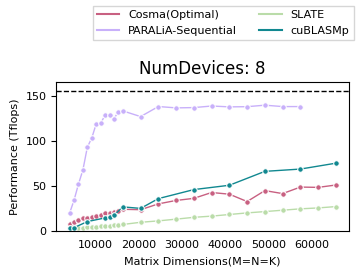

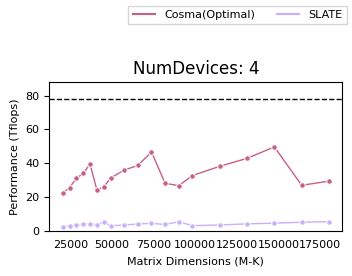

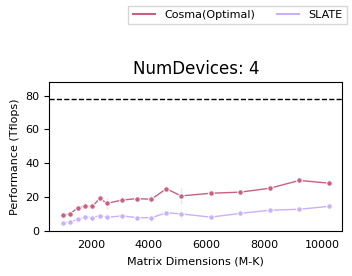

In [182]:
#------------- SIMPLE PERFORMANCE/ SOTA COMPARISON PLOT  --------------------#
def plotSquarePerformanceComparison(dataset, numberOfDevices, saveResults, filepath):
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=filterNumberOfDevices(dataset, numberOfDevices), x='M', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    ax.axhline(y = (numberOfDevices)*19.5, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, (numberOfDevices)*19.5 + 10])
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Matrix Dimensions(M=N=K)')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    plt.title(f"NumDevices: {numberOfDevices}")
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-Square{numberOfDevices}.png' )

def plotThinToFatPerformanceComparison(dataset, numberOfDevices, saveResults):
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=filterNumberOfDevices(dataset, numberOfDevices), x='K', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    ax.axhline(y = (numberOfDevices)*19.5, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, (numberOfDevices)*19.5 + 10])
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Matrix Dimensions (M-K)')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    plt.title(f"NumDevices: {numberOfDevices}")
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-ThinToFat-{numberOfDevices}.png')

def plotFatToThinPerformanceComparison(dataset, numberOfDevices, saveResults):
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=filterNumberOfDevices(dataset, numberOfDevices), x='K', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    ax.axhline(y = (numberOfDevices)*19.5, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, (numberOfDevices)*19.5 + 10])
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Matrix Dimensions (M-K)')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    plt.title(f"NumDevices: {numberOfDevices}")
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-FatToThin-{numberOfDevices}.png')

def plotDeviceUtilizationPercentage(dataset, numberOfDevices, saveResults):
    pass


plotSquarePerformanceComparison(squareDataset, 8, True, "")
# plotSquarePerformanceComparison(squareDataset, 16, True, "")

plotThinToFatPerformanceComparison(thinToFatDataset, 4, True)
# plotThinToFatPerformanceComparison(thinToFatDataset, 8, True)
# plotThinToFatPerformanceComparison(thinToFatDataset, 16, True)

plotFatToThinPerformanceComparison(fatToThinDataset, 4, True)
# plotFatToThinPerformanceComparison(fatToThinDataset, 8, True)
# plotFatToThinPerformanceComparison(fatToThinDataset, 16, True)

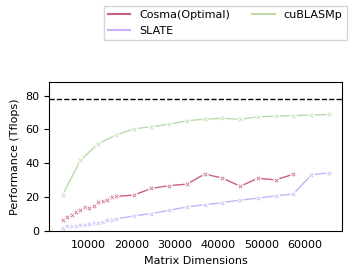

In [183]:
#------------- SINGLE NODE PERFORMANCE FOR UNCUT GEMMS (REBUTTAL) --------------------#
sns.set_palette(color_map[1:])

fig, ax = plt.subplots(1,1)

axout = sns.lineplot(data=filterNumberOfDevices(squareDataset, 4), x='M', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'X', markersize = 4, linewidth = 1)

ax.axhline(y = 4*19.5, color = 'k', linestyle = '--', linewidth = 1)

ax.set_ylim([0, 4*19.5 + 10])
plt.tick_params(bottom = False)
ax.get_legend().remove()
ax.set_xlabel('Matrix Dimensions')

fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
fig.set_size_inches(width, height*1.2)

fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
fig.savefig('plots/%s-PreDistributed-SingleNode-DGEMM.png' % "meluxina")

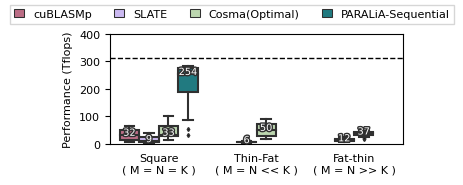

In [184]:
#------------- SIMPLE PERFORMANCE/ SOTA COMPARISON PLOT BOXPLOT --------------------#
def add_median_labels(ax: plt.Axes, offset: int, fmt: str = "d") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y + offset, f'{int(value):{fmt}}', ha='center', va='center',
                       color='white', fontsize = font-1) #fontweight='bold', 
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

dataset_plotlist = pd.concat([squareDataset,fatToThinDataset,thinToFatDataset])
dataset_plotlist.sort_values(inplace = True, by = ['PlotOrder'])
def plotPerformanceComparisonBoxplot(dataset, numDevices, saveResults):
    flierprops = dict(markerfacecolor='k', markersize=2,
                linestyle='none')
    fig, ax = plt.subplots(1,1)
    axout = sns.boxplot(data=filterNumberOfDevices(dataset_plotlist, numDevices), x = 'shape', hue = 'Algo', y = 'Performance (Tflops)', ax=ax, flierprops=flierprops)
    ax.axhline(y = 19.5*numDevices, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0,25*numDevices])
    plt.tick_params(bottom = False) 
    add_median_labels(axout, 7)
    ax.get_legend().remove()
    ax.set_xlabel('')
    #ax.set_xticklabels(elem_name, rotation = 15)
    fig.legend(loc = 'upper center',#title="Model",  # Title for the legend
        fontsize=font, fancybox = False, ncol=10, handlelength=0.9)
    fig.set_size_inches(width, height*0.8)
    fig.subplots_adjust(left=.15, bottom=.15/0.8, right=.99, top=1-((1 - .86)/0.8))
    machineName = "meluxina"
    if (saveResults):
        fig.savefig(f'plots/{machineName}-PreDistributed-BoxPlot-DGEMM-{numDevices}.png') 

# plotPerformanceComparisonBoxplot(dataset_plotlist, 4, True)
# plotPerformanceComparisonBoxplot(dataset_plotlist, 8, True)
plotPerformanceComparisonBoxplot(dataset_plotlist, 16, True)

                   Algo      M      N      K  TotalGPUs DataLocation  \
258      Cosma(Optimal)  65536  65536  65536          8         host   
259      Cosma(Optimal)  65536  65536  65536         16         host   
311  PARALiA-Sequential  65536  65536  65536         16      devices   
575               SLATE  65536  65536  65536          4      devices   
576               SLATE  65536  65536  65536          8      devices   
577               SLATE  65536  65536  65536         16      devices   
618            cuBLASMp  65536  65536  65536          4      devices   
619            cuBLASMp  65536  65536  65536          8      devices   
620            cuBLASMp  65536  65536  65536         16      devices   

     TileRows  TileColumns  dRow  dCol  ...  HostToDeviceTime    GatherTime  \
258       NaN          NaN   NaN   NaN  ...               NaN           NaN   
259       NaN          NaN   NaN   NaN  ...               NaN           NaN   
311       NaN          NaN   2.0   2.0  ..

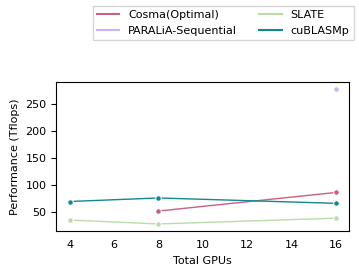

In [185]:
#------------- STRONG SCALING BENCHMARK - (M=N=K=128k) --------------------#
def plotStrongScaling(dataset, problemSize, saveResults, filepath):
    dataset = strongScalingLimits(dataset, problemSize)
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=dataset, x='TotalGPUs', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Total GPUs')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-StongScaling.png')
print(strongScalingLimits(squareDataset, 2**16))
plotStrongScaling(squareDataset, 2**16, True, "")

                   Algo      M      N      K  TotalGPUs DataLocation  \
258      Cosma(Optimal)  65536  65536  65536          8         host   
259      Cosma(Optimal)  65536  65536  65536         16         host   
311  PARALiA-Sequential  65536  65536  65536         16      devices   
575               SLATE  65536  65536  65536          4      devices   
576               SLATE  65536  65536  65536          8      devices   
577               SLATE  65536  65536  65536         16      devices   
618            cuBLASMp  65536  65536  65536          4      devices   
619            cuBLASMp  65536  65536  65536          8      devices   
620            cuBLASMp  65536  65536  65536         16      devices   

     TileRows  TileColumns  dRow  dCol  ...  HostToDeviceTime    GatherTime  \
258       NaN          NaN   NaN   NaN  ...               NaN           NaN   
259       NaN          NaN   NaN   NaN  ...               NaN           NaN   
311       NaN          NaN   2.0   2.0  ..

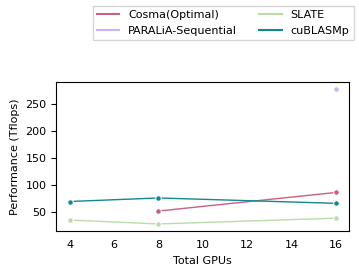

In [186]:
#------------- WEAK SCALING BENCHMARK - (M=N=K=4096*numDevices) (numDevices: 2-64) ({2,4,8,16,24,32,48,64}) --------------------#
def plotWeakScaling(dataset, problemSize, saveResults, filepath):
    dataset = strongScalingLimits(dataset, problemSize)
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=dataset, x='TotalGPUs', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Total GPUs')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-WeakScaling.png')
print(strongScalingLimits(squareDataset, 2**16))
plotStrongScaling(squareDataset, 2**16, True, "")

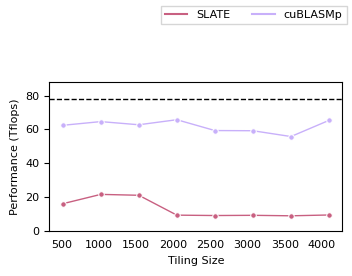

In [187]:
#------------- Tiling BENCHMARK - (M=N=K=32k) (Devices: 16) --------------------#
tilingDataset = pd.DataFrame()

cuBLASMpTiling = readLogFile("tiling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-cuBLASMp.csv")
cuBLASMpTiling['DataLocation'] = "devices"
tilingDataset = pd.concat([tilingDataset,cuBLASMpTiling])

slateTiling = readLogFile("tiling/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-SLATE.csv")
tilingDataset = pd.concat([tilingDataset,slateTiling])

# Group Dataset by Tiles
tilingDataset = groupByTiles(tilingDataset, 32768)
tilingDataset['Performance (Tflops)'] = tilingDataset['GFlops']/1024

def plotTilingBenchmark(dataset, numberOfDevices, saveResults, filepath):
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=filterNumberOfDevices(dataset, numberOfDevices), x='TileRows', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    ax.axhline(y = (numberOfDevices)*19.5, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, (numberOfDevices)*19.5 + 10])
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Tiling Size')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-TilingPerformance-DGEMM-{numberOfDevices}.png' )

plotTilingBenchmark(tilingDataset, 4, True, " ")
tilingDataset.to_csv("tilingDataset.csv", index=False)

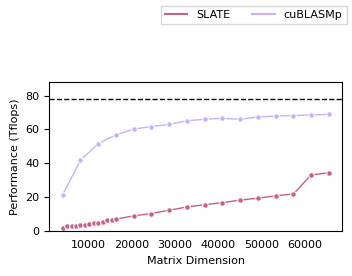

In [188]:
#------------- ScaLAPACK Decomposition (SLATE, COSMA(ScaLAPACK), cuBLASMp) --------------------#
def plotScalapackDecompPerformanceComparison(dataset, numberOfDevices, saveResults, filepath):
    sns.set_palette(color_map[1:])
    fig, ax = plt.subplots(1,1)
    axout = sns.lineplot(data=filterNumberOfDevices(dataset, numberOfDevices), x='M', y = 'Performance (Tflops)', hue='Algo', ax=ax, marker = 'o', markersize = 4, linewidth = 1)
    ax.axhline(y = (numberOfDevices)*19.5, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, (numberOfDevices)*19.5 + 10])
    plt.tick_params(bottom = False)
    ax.get_legend().remove()
    ax.set_xlabel('Matrix Dimension')
    fig.legend(loc = 'upper right', fontsize = 8, fancybox = False, ncol = 2)
    fig.set_size_inches(width, height*1.2)
    fig.subplots_adjust(left=.15, bottom=.15/1.2, right=.99, top=1-((1 - .64)/1.2))
    systemName="meluxina"
    if (saveResults):
        fig.savefig(f'plots/{systemName}-ScalapackDecompositionComparison-DGEMM-{numberOfDevices}.png')

plotScalapackDecompPerformanceComparison(scalapackDataset, 4, True, "")

In [189]:
#------------- Execution Analysis (PARALiA) --------------------#
def plotExecutionAnalysis(dataset, saveResults):
    
    pass